In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
#from custom_classes_defs.Unet_like import * 
from custom_classes_defs.unet import *   
# from custom_classes_defs.fnet import * 
# from custom_classes_defs.fnet1 import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247

BATCH_SIZE = 256
# size 512 to have around 351 iterations
# size 256 to have around 707 iterations

keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

NEW_SESSION = False

# import keras_tuner as kt
# -------------------------------------------------------

2024-05-06 23:03:08.086222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 23:03:08.086851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 23:03:08.208198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 23:03:08.468251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

#if NUM_GPU:
#    # print GPU info
#    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


In [6]:
# Input data path
seis_path = './data_thebe/seis/'
label_path = './data_thebe/fault/'


In [7]:
time_start= time.time()
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train',cache=True)
val_dataset = thebe_data.data_generator(sub_group='val',cache= True)
test_dataset = thebe_data.data_generator(sub_group='test',cache= True)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

./data_thebe/seis/train/seis_train.npy
./data_thebe/fault/train/fault_train.npy


2024-05-06 23:05:39.112732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Loading time used 3.4669920285542806 mins


In [8]:
print(f"training data (size = {(train_dataset.cardinality().numpy())*BATCH_SIZE})")
print(f"validation data (size = {(val_dataset.cardinality().numpy())*BATCH_SIZE})")
print(f"test data (size = {(test_dataset.cardinality().numpy())*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])

training data (size = 181248)
validation data (size = 64512)
test data (size = 66304)
Data images tensor: TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None)


In [9]:


# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=0,
    scaling=1,
    save_path='./output/unet',
    img_shape= (96,96),
    target_size= (96,96),
    channels_dim=(1,1),
    pos_label= thebe_data.pos_label,
    new_training_session=True,
    mixed_precision = False,
    multiple_gpu_device=None
)


callbacks=conf.callbacks(chkpt_monitor='val_loss', lr_patience= 5)
conf.set( validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 100
                    batch_size: 256
                       shuffle: False
                       verbose: 0
               validation_data: <class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
                     callbacks: <keras.src.callbacks.ReduceLROnPlateau object at 0x7fb582d3bf10>
                              : <keras.src.callbacks.ModelCheckpoint object at 0x7fb585a0a610>
                              : <keras.src.callbacks.EarlyStopping object at 0x7fb582d3bc90>
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
new_training_session: True
           save_path: ./outp

### Build model

In [10]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

#model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 3,083,969
Total trainable wieghts: 3,080,193
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-06 23:08:06.420999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-06 23:08:07.831769: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-06 23:08:30.642044: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fafec4e2870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 23:08:30.642097: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0


2024-05-06 23:08:30.975421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715029712.581681 2608770 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.



Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



Epoch 21: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


training elapsed time: ___25.55___ minutes
...training completed!


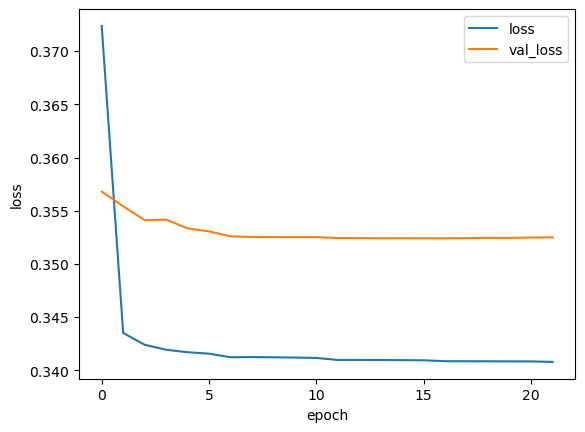

Loading time used 25.592709116141002 mins


In [11]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

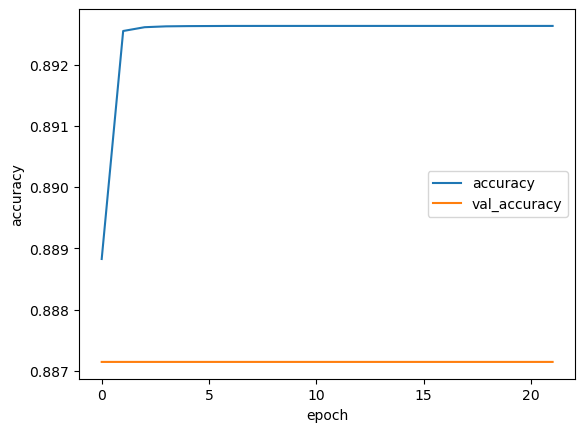

In [12]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

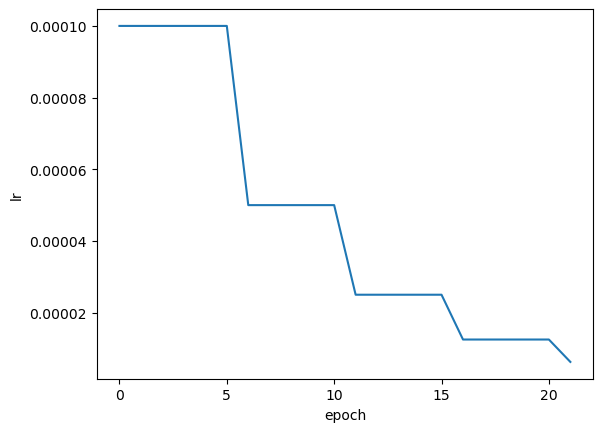

In [13]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [14]:
time_start= time.time()
y_preds = model.predict(test_dataset)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

  1/259 [..............................] - ETA: 11:01

  3/259 [..............................] - ETA: 7s   

  5/259 [..............................] - ETA: 7s

  7/259 [..............................] - ETA: 7s

  9/259 [>.............................] - ETA: 6s

 12/259 [>.............................] - ETA: 6s

 14/259 [>.............................] - ETA: 6s

 16/259 [>.............................] - ETA: 6s

 18/259 [=>............................] - ETA: 6s

 20/259 [=>............................] - ETA: 6s

 22/259 [=>............................] - ETA: 6s

 24/259 [=>............................] - ETA: 6s

 27/259 [==>...........................] - ETA: 6s

 30/259 [==>...........................] - ETA: 5s

 32/259 [==>...........................] - ETA: 5s

 35/259 [===>..........................] - ETA: 5s

 38/259 [===>..........................] - ETA: 5s

 41/259 [===>..........................] - ETA: 5s

 44/259 [====>.........................] - ETA: 5s

 47/259 [====>.........................] - ETA: 5s

 49/259 [====>.........................] - ETA: 5s

 51/259 [====>.........................] - ETA: 5s

 54/259 [=====>........................] - ETA: 5s

 56/259 [=====>........................] - ETA: 5s

 58/259 [=====>........................] - ETA: 5s

 60/259 [=====>........................] - ETA: 5s

 62/259 [======>.......................] - ETA: 5s

 64/259 [======>.......................] - ETA: 5s

 66/259 [======>.......................] - ETA: 4s

 69/259 [======>.......................] - ETA: 4s

 72/259 [=======>......................] - ETA: 4s

 74/259 [=======>......................] - ETA: 4s

 76/259 [=======>......................] - ETA: 4s

 78/259 [========>.....................] - ETA: 4s

 80/259 [========>.....................] - ETA: 4s

 82/259 [========>.....................] - ETA: 4s

 84/259 [========>.....................] - ETA: 4s

 86/259 [========>.....................] - ETA: 4s

 88/259 [=========>....................] - ETA: 4s

 90/259 [=========>....................] - ETA: 4s

 93/259 [=========>....................] - ETA: 4s

 95/259 [==========>...................] - ETA: 4s

 98/259 [==========>...................] - ETA: 4s

100/259 [==========>...................] - ETA: 4s

103/259 [==========>...................] - ETA: 3s

106/259 [===========>..................] - ETA: 3s

108/259 [===========>..................] - ETA: 3s

111/259 [===========>..................] - ETA: 3s

113/259 [============>.................] - ETA: 3s

116/259 [============>.................] - ETA: 3s

119/259 [============>.................] - ETA: 3s

121/259 [=============>................] - ETA: 3s

123/259 [=============>................] - ETA: 3s

125/259 [=============>................] - ETA: 3s

127/259 [=============>................] - ETA: 3s

129/259 [=============>................] - ETA: 3s

132/259 [==============>...............] - ETA: 3s

135/259 [==============>...............] - ETA: 3s

137/259 [==============>...............] - ETA: 3s

140/259 [===============>..............] - ETA: 3s

143/259 [===============>..............] - ETA: 2s

145/259 [===============>..............] - ETA: 2s

148/259 [================>.............] - ETA: 2s

150/259 [================>.............] - ETA: 2s

153/259 [================>.............] - ETA: 2s

156/259 [=================>............] - ETA: 2s

159/259 [=================>............] - ETA: 2s

162/259 [=================>............] - ETA: 2s

164/259 [=================>............] - ETA: 2s

167/259 [==================>...........] - ETA: 2s

170/259 [==================>...........] - ETA: 2s

173/259 [===================>..........] - ETA: 2s

176/259 [===================>..........] - ETA: 2s

179/259 [===================>..........] - ETA: 2s

182/259 [====================>.........] - ETA: 1s

184/259 [====================>.........] - ETA: 1s

187/259 [====================>.........] - ETA: 1s

190/259 [=====================>........] - ETA: 1s

193/259 [=====================>........] - ETA: 1s

196/259 [=====================>........] - ETA: 1s

199/259 [======================>.......] - ETA: 1s

202/259 [======================>.......] - ETA: 1s

205/259 [======================>.......] - ETA: 1s

207/259 [======================>.......] - ETA: 1s

210/259 [=======================>......] - ETA: 1s

213/259 [=======================>......] - ETA: 1s

215/259 [=======================>......] - ETA: 1s

218/259 [========================>.....] - ETA: 1s

220/259 [========================>.....] - ETA: 0s

223/259 [========================>.....] - ETA: 0s

226/259 [=========================>....] - ETA: 0s

228/259 [=========================>....] - ETA: 0s

231/259 [=========================>....] - ETA: 0s

234/259 [==========================>...] - ETA: 0s

236/259 [==========================>...] - ETA: 0s

239/259 [==========================>...] - ETA: 0s

242/259 [===========================>..] - ETA: 0s

244/259 [===========================>..] - ETA: 0s

247/259 [===========================>..] - ETA: 0s

249/259 [===========================>..] - ETA: 0s

252/259 [============================>.] - ETA: 0s

255/259 [============================>.] - ETA: 0s

258/259 [============================>.] - ETA: 0s

259/259 [==============================] - ETA: 0s

259/259 [==============================] - 10s 28ms/step


Loading time used 0.21433729728062947 mins


In [15]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

model.evaluate(x=test_dataset)
time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')



	Evaluate unet model
-------------------------------------------------------
  1/259 [..............................] - ETA: 8s - loss: 0.3361 - accuracy: 0.8950

  3/259 [..............................] - ETA: 8s - loss: 0.3368 - accuracy: 0.8947

  5/259 [..............................] - ETA: 7s - loss: 0.3387 - accuracy: 0.8938

  7/259 [..............................] - ETA: 7s - loss: 0.3410 - accuracy: 0.8927

  9/259 [>.............................] - ETA: 7s - loss: 0.3407 - accuracy: 0.8929

 11/259 [>.............................] - ETA: 7s - loss: 0.3409 - accuracy: 0.8928

 13/259 [>.............................] - ETA: 7s - loss: 0.3397 - accuracy: 0.8934

 15/259 [>.............................] - ETA: 6s - loss: 0.3393 - accuracy: 0.8936

 17/259 [>.............................] - ETA: 6s - loss: 0.3385 - accuracy: 0.8939

 19/259 [=>............................] - ETA: 6s - loss: 0.3387 - accuracy: 0.8938

 21/259 [=>............................] - ETA: 6s - loss: 0.3392 - accuracy: 0.8936

 23/259 [=>............................] - ETA: 6s - loss: 0.3391 - accuracy: 0.8937

 25/259 [=>............................] - ETA: 6s - loss: 0.3383 - accuracy: 0.8940

 27/259 [==>...........................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8942

 29/259 [==>...........................] - ETA: 6s - loss: 0.3381 - accuracy: 0.8941

 31/259 [==>...........................] - ETA: 6s - loss: 0.3384 - accuracy: 0.8940

 33/259 [==>...........................] - ETA: 6s - loss: 0.3383 - accuracy: 0.8941

 35/259 [===>..........................] - ETA: 6s - loss: 0.3384 - accuracy: 0.8940

 37/259 [===>..........................] - ETA: 6s - loss: 0.3383 - accuracy: 0.8941

 39/259 [===>..........................] - ETA: 6s - loss: 0.3382 - accuracy: 0.8941

 41/259 [===>..........................] - ETA: 6s - loss: 0.3382 - accuracy: 0.8941

 43/259 [===>..........................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8941

 45/259 [====>.........................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8941

 47/259 [====>.........................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8942

 49/259 [====>.........................] - ETA: 5s - loss: 0.3379 - accuracy: 0.8943

 51/259 [====>.........................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8941

 53/259 [=====>........................] - ETA: 5s - loss: 0.3383 - accuracy: 0.8941

 55/259 [=====>........................] - ETA: 5s - loss: 0.3383 - accuracy: 0.8941

 57/259 [=====>........................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8941

 59/259 [=====>........................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8941

 61/259 [======>.......................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8941

 63/259 [======>.......................] - ETA: 5s - loss: 0.3383 - accuracy: 0.8940

 65/259 [======>.......................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8941

 67/259 [======>.......................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8941

 69/259 [======>.......................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8941

 71/259 [=======>......................] - ETA: 5s - loss: 0.3380 - accuracy: 0.8942

 73/259 [=======>......................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8942

 75/259 [=======>......................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8941

 77/259 [=======>......................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8941

 79/259 [========>.....................] - ETA: 4s - loss: 0.3382 - accuracy: 0.8941

 81/259 [========>.....................] - ETA: 4s - loss: 0.3382 - accuracy: 0.8941

 83/259 [========>.....................] - ETA: 4s - loss: 0.3384 - accuracy: 0.8940

 85/259 [========>.....................] - ETA: 4s - loss: 0.3384 - accuracy: 0.8940

 87/259 [=========>....................] - ETA: 4s - loss: 0.3384 - accuracy: 0.8940

 89/259 [=========>....................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8940

 91/259 [=========>....................] - ETA: 4s - loss: 0.3385 - accuracy: 0.8940

 93/259 [=========>....................] - ETA: 4s - loss: 0.3385 - accuracy: 0.8939

 95/259 [==========>...................] - ETA: 4s - loss: 0.3386 - accuracy: 0.8939

 97/259 [==========>...................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8938

 99/259 [==========>...................] - ETA: 4s - loss: 0.3388 - accuracy: 0.8938

101/259 [==========>...................] - ETA: 4s - loss: 0.3388 - accuracy: 0.8938

103/259 [==========>...................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8938

105/259 [===========>..................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8938

107/259 [===========>..................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8938

109/259 [===========>..................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8938

111/259 [===========>..................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8938

113/259 [============>.................] - ETA: 4s - loss: 0.3388 - accuracy: 0.8938

115/259 [============>.................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8938

117/259 [============>.................] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939

119/259 [============>.................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8938

121/259 [=============>................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939

123/259 [=============>................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939

125/259 [=============>................] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939

127/259 [=============>................] - ETA: 3s - loss: 0.3385 - accuracy: 0.8939

129/259 [=============>................] - ETA: 3s - loss: 0.3385 - accuracy: 0.8939

131/259 [==============>...............] - ETA: 3s - loss: 0.3385 - accuracy: 0.8940

133/259 [==============>...............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939

135/259 [==============>...............] - ETA: 3s - loss: 0.3385 - accuracy: 0.8940

137/259 [==============>...............] - ETA: 3s - loss: 0.3384 - accuracy: 0.8940

139/259 [===============>..............] - ETA: 3s - loss: 0.3385 - accuracy: 0.8939

141/259 [===============>..............] - ETA: 3s - loss: 0.3385 - accuracy: 0.8939

143/259 [===============>..............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939

145/259 [===============>..............] - ETA: 3s - loss: 0.3385 - accuracy: 0.8939

147/259 [================>.............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939

149/259 [================>.............] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939

151/259 [================>.............] - ETA: 2s - loss: 0.3387 - accuracy: 0.8939

153/259 [================>.............] - ETA: 2s - loss: 0.3387 - accuracy: 0.8938

155/259 [================>.............] - ETA: 2s - loss: 0.3388 - accuracy: 0.8938

157/259 [=================>............] - ETA: 2s - loss: 0.3389 - accuracy: 0.8937

159/259 [=================>............] - ETA: 2s - loss: 0.3389 - accuracy: 0.8937

161/259 [=================>............] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938

163/259 [=================>............] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938

165/259 [==================>...........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8938

167/259 [==================>...........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8938

169/259 [==================>...........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8938

171/259 [==================>...........] - ETA: 2s - loss: 0.3387 - accuracy: 0.8938

173/259 [===================>..........] - ETA: 2s - loss: 0.3386 - accuracy: 0.8939

175/259 [===================>..........] - ETA: 2s - loss: 0.3386 - accuracy: 0.8939

177/259 [===================>..........] - ETA: 2s - loss: 0.3387 - accuracy: 0.8938

179/259 [===================>..........] - ETA: 2s - loss: 0.3387 - accuracy: 0.8938

181/259 [===================>..........] - ETA: 2s - loss: 0.3387 - accuracy: 0.8939

183/259 [====================>.........] - ETA: 2s - loss: 0.3387 - accuracy: 0.8938

185/259 [====================>.........] - ETA: 2s - loss: 0.3387 - accuracy: 0.8938

187/259 [====================>.........] - ETA: 1s - loss: 0.3387 - accuracy: 0.8939

189/259 [====================>.........] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

191/259 [=====================>........] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938

193/259 [=====================>........] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938

195/259 [=====================>........] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

197/259 [=====================>........] - ETA: 1s - loss: 0.3387 - accuracy: 0.8939

199/259 [======================>.......] - ETA: 1s - loss: 0.3387 - accuracy: 0.8939

201/259 [======================>.......] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

203/259 [======================>.......] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

205/259 [======================>.......] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938

207/259 [======================>.......] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

209/259 [=======================>......] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

211/259 [=======================>......] - ETA: 1s - loss: 0.3387 - accuracy: 0.8938

213/259 [=======================>......] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938

215/259 [=======================>......] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938

217/259 [========================>.....] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938

219/259 [========================>.....] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938

221/259 [========================>.....] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938

223/259 [========================>.....] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

225/259 [=========================>....] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

227/259 [=========================>....] - ETA: 0s - loss: 0.3389 - accuracy: 0.8938

229/259 [=========================>....] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

231/259 [=========================>....] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

233/259 [=========================>....] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

235/259 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

237/259 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

239/259 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

241/259 [==========================>...] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

243/259 [===========================>..] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

245/259 [===========================>..] - ETA: 0s - loss: 0.3388 - accuracy: 0.8938

247/259 [===========================>..] - ETA: 0s - loss: 0.3387 - accuracy: 0.8938

249/259 [===========================>..] - ETA: 0s - loss: 0.3387 - accuracy: 0.8939

251/259 [============================>.] - ETA: 0s - loss: 0.3387 - accuracy: 0.8939

253/259 [============================>.] - ETA: 0s - loss: 0.3387 - accuracy: 0.8939

255/259 [============================>.] - ETA: 0s - loss: 0.3387 - accuracy: 0.8939

257/259 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.8939

259/259 [==============================] - 7s 27ms/step - loss: 0.3386 - accuracy: 0.8939


Loading time used 0.11847041845321656 mins


In [16]:
# Using scikit-learn
scores = m_obj.evaluate_sklearn(test_dataset, y_preds,report=True)
print(scores)


evaluation elapsed time:___32.11___minutes
                      0            1  accuracy     macro avg  weighted avg
precision  9.000000e-01         0.11       0.5  5.000000e-01  8.100000e-01
recall     5.000000e-01         0.51       0.5  5.100000e-01  5.000000e-01
f1-score   6.400000e-01         0.18       0.5  4.100000e-01  5.900000e-01
support    5.443481e+08  64617490.00       0.5  6.089656e+08  6.089656e+08
{'Avg-precision': 0.11, 'f1-score(ODS)': 0.18}


In [17]:
if NEW_SESSION:
    thebe_data.display_sample_image(y_preds, 'test')